In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-unet-collection

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_unet_collection import models
from keras import backend as K

In [ ]:
#datapath = '/content/drive/MyDrive/2023_02/RV/Tarea 4/T4 Dataset
#datapath = '/content/drive/MyDrive/Tarea_4/T4 Dataset/T4 Dataset/'
datapath = '/content/drive/MyDrive/T4 Dataset'

#Funcion Loss

In [ ]:
def dice_coef(y_true, y_pred):
  smooth = 1.0
  # print(y_true.shape())
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  up = (2.0 * intersection + smooth)
  down = (K.sum(y_true_f) + K.sum(y_pred_f) + smooth )
  return up / down

def bce_dice_loss(y_true, y_pred) :
  celoss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
  return celoss + (1 - dice_coef(y_true, y_pred))

#Pre-procesamiento

In [ ]:
datagenkwargs = dict(rescale = 1./255, validation_split=0.2)
imagedatagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagenkwargs)
maskdatagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagenkwargs)

imagespath = os.path.normpath(os.path.join(datapath, 'Images'))
maskspath = os.path.normpath(os.path.join(datapath, 'Masks'))
train_image_generator = imagedatagen.flow_from_directory(imagespath,
      target_size = (128,128),
      color_mode = 'grayscale',
      class_mode = None,
      batch_size = 32,
      shuffle = True,
      seed = 42,
      subset = 'training'
      )
train_mask_generator = maskdatagen.flow_from_directory(maskspath,
      target_size = (128,128),
      color_mode = 'grayscale',
      class_mode = None,
      batch_size = 32,
      shuffle = True,
      seed = 42,
      subset = 'training'
      )
test_image_generator = imagedatagen.flow_from_directory(imagespath,
      target_size = (128,128),
      color_mode = 'grayscale',
      class_mode = None,
      batch_size = 32,
      shuffle = True,
      seed = 42,
      subset = 'validation'
      )
test_mask_generator = maskdatagen.flow_from_directory(maskspath,
      target_size = (128,128),
      color_mode = 'grayscale',
      class_mode = None,
      batch_size = 32,
      shuffle = True,
      seed = 42,
      subset = 'validation'
      )
train_datagen = zip(train_image_generator, train_mask_generator)
test_datagen = zip(test_image_generator, test_mask_generator)

Found 542 images belonging to 1 classes.
Found 542 images belonging to 1 classes.
Found 135 images belonging to 1 classes.
Found 135 images belonging to 1 classes.


#Creacion de Modelos


In [ ]:
batch_size = 32

total_train = train_image_generator.samples
total_val = test_image_generator.samples

steps_epoch = total_train // batch_size
val_steps = total_val // batch_size


In [ ]:
from keras_unet_collection import models
import tensorflow as tf

# Para unet_2d
unet = models.unet_2d(input_size=(128, 128, 1),
                      filter_num=[64, 128, 256, 512],
                      n_labels=1,
                      output_activation = "Sigmoid"
                      )


# Para unet_plus_2d
unetplus = models.unet_plus_2d(input_size=(128, 128, 1),
                               filter_num=[64, 128, 256, 512],
                               n_labels=1,
                               output_activation = "Sigmoid"
                               )



In [ ]:
opt = tf.keras.optimizers.Adam()
unet.compile(
         optimizer=opt,
          loss=bce_dice_loss,
          metrics=[dice_coef]
          )

unet.summary()


Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 unet_down0_0 (Conv2D)       (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 unet_down0_0_activation (R  (None, 128, 128, 64)         0         ['unet_down0_0[0][0]']        
 eLU)                                                                                             
                                                                                                  
 unet_down0_1 (Conv2D)       (None, 128, 128, 64)         36928     ['unet_down0_0_activa

In [ ]:
history = unet.fit(train_datagen, epochs=10, batch_size=32, validation_data=test_datagen, validation_steps=val_steps, steps_per_epoch=steps_epoch)

Epoch 1/10
16/16 [==============================] - 149s 8s/step - loss: 1.2769 - dice_coef: 0.3087 - val_loss: 1.2101 - val_dice_coef: 0.2898
Epoch 2/10
16/16 [==============================] - 128s 8s/step - loss: 1.1250 - dice_coef: 0.3631 - val_loss: 1.0696 - val_dice_coef: 0.3565
Epoch 3/10
16/16 [==============================] - 112s 7s/step - loss: 0.9227 - dice_coef: 0.4591 - val_loss: 0.8222 - val_dice_coef: 0.4952
Epoch 4/10
16/16 [==============================] - 108s 7s/step - loss: 0.7588 - dice_coef: 0.5743 - val_loss: 0.5786 - val_dice_coef: 0.7185
Epoch 5/10
16/16 [==============================] - 114s 8s/step - loss: 0.5332 - dice_coef: 0.7470 - val_loss: 0.6392 - val_dice_coef: 0.6227
Epoch 6/10
16/16 [==============================] - 112s 7s/step - loss: 0.3894 - dice_coef: 0.8063 - val_loss: 0.2936 - val_dice_coef: 0.8479
Epoch 7/10
16/16 [==============================] - 123s 8s/step - loss: 0.2411 - dice_coef: 0.8887 - val_loss: 0.2221 - val_dice_coef: 0.8883

In [ ]:
opt = tf.keras.optimizers.Adam()
#Agregar las funciones del enunciado de sobre el error

unetplus.compile(
         optimizer=opt,
          loss=bce_dice_loss,
          metrics=[dice_coef])

unetplus.summary()

history2 = unetplus.fit(train_datagen, epochs=10, batch_size=32, validation_data=test_datagen, validation_steps=val_steps, steps_per_epoch=steps_epoch)



Model: "xnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 xnet_down0_0 (Conv2D)       (None, 128, 128, 64)      640       
                                                                 
 xnet_down0_0_activation (R  (None, 128, 128, 64)      0         
 eLU)                                                            
                                                                 
 xnet_down0_1 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 xnet_down0_1_activation (R  (None, 128, 128, 64)      0         
 eLU)                                                            
                                                                 
 xnet_down1_encode_maxpool   (None, 64, 64, 64)        0

In [ ]:
eval_unet = unet.evaluate(test_datagen, steps=val_steps)
eval_unetplus = unetplus.evaluate(test_datagen, steps=val_steps)


4/4 [==============================] - 13s 4s/step - loss: 0.2173 - dice_coef: 0.8859


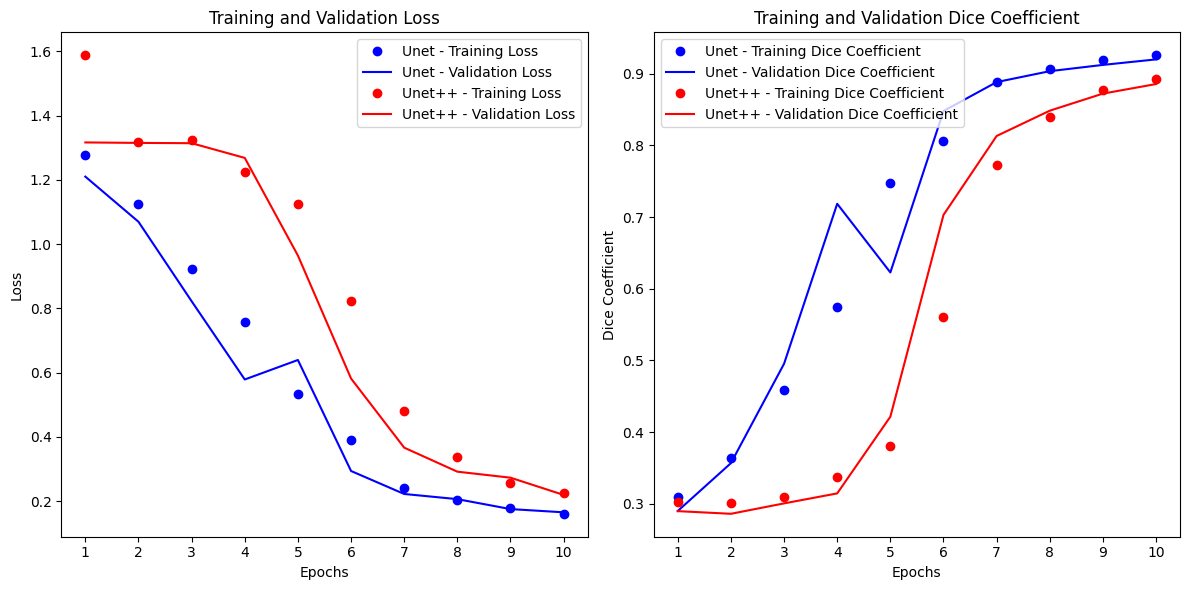

In [ ]:
# Obtener las pérdidas y coeficientes de Dice de entrenamiento y validación para ambos modelos
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
train_dice2 = history2.history['dice_coef']
val_dice2 = history2.history['val_dice_coef']

# Crear un gráfico para la pérdida
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Unet - Training Loss')
plt.plot(epochs, val_loss, 'b', label='Unet - Validation Loss')
plt.plot(epochs, train_loss2, 'ro', label='Unet++ - Training Loss')
plt.plot(epochs, val_loss2, 'r', label='Unet++ - Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Configurar etiquetas del eje x como números enteros
plt.xticks(np.arange(1, len(epochs) + 1, 1))

# Crear un gráfico para el coeficiente de Dice
plt.subplot(1, 2, 2)
plt.plot(epochs, train_dice, 'bo', label='Unet - Training Dice Coefficient')
plt.plot(epochs, val_dice, 'b', label='Unet - Validation Dice Coefficient')
plt.plot(epochs, train_dice2, 'ro', label='Unet++ - Training Dice Coefficient')
plt.plot(epochs, val_dice2, 'r', label='Unet++ - Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

# Configurar etiquetas del eje x como números enteros
plt.xticks(np.arange(1, len(epochs) + 1, 1))

# Mostrar los gráficos
plt.tight_layout()
plt.show()

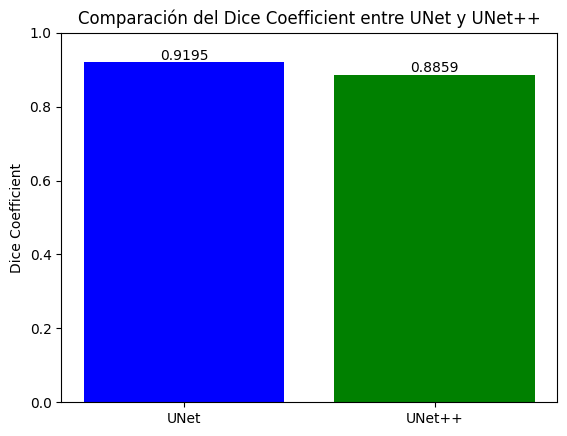

In [ ]:
import matplotlib.pyplot as plt

# Resultados de la evaluación
dice_coef_unet = eval_unet[1]
dice_coef_unetplus = eval_unetplus[1]

# Nombres de los modelos
model_names = ['UNet', 'UNet++']

# Valores de los coeficientes Dice
dice_coefs = [dice_coef_unet, dice_coef_unetplus]

# Crear un gráfico de barras con etiquetas
fig, ax = plt.subplots()
bars = ax.bar(model_names, dice_coefs, color=['blue', 'green'])

# Agregar etiquetas con los valores numéricos encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.ylabel('Dice Coefficient')
plt.title('Comparación del Dice Coefficient entre UNet y UNet++')
plt.ylim([0, 1])  # Establecer el rango del eje y entre 0 y 1 para el coeficiente Dice
plt.show()


1/1 [==============================] - 0s 308ms/step


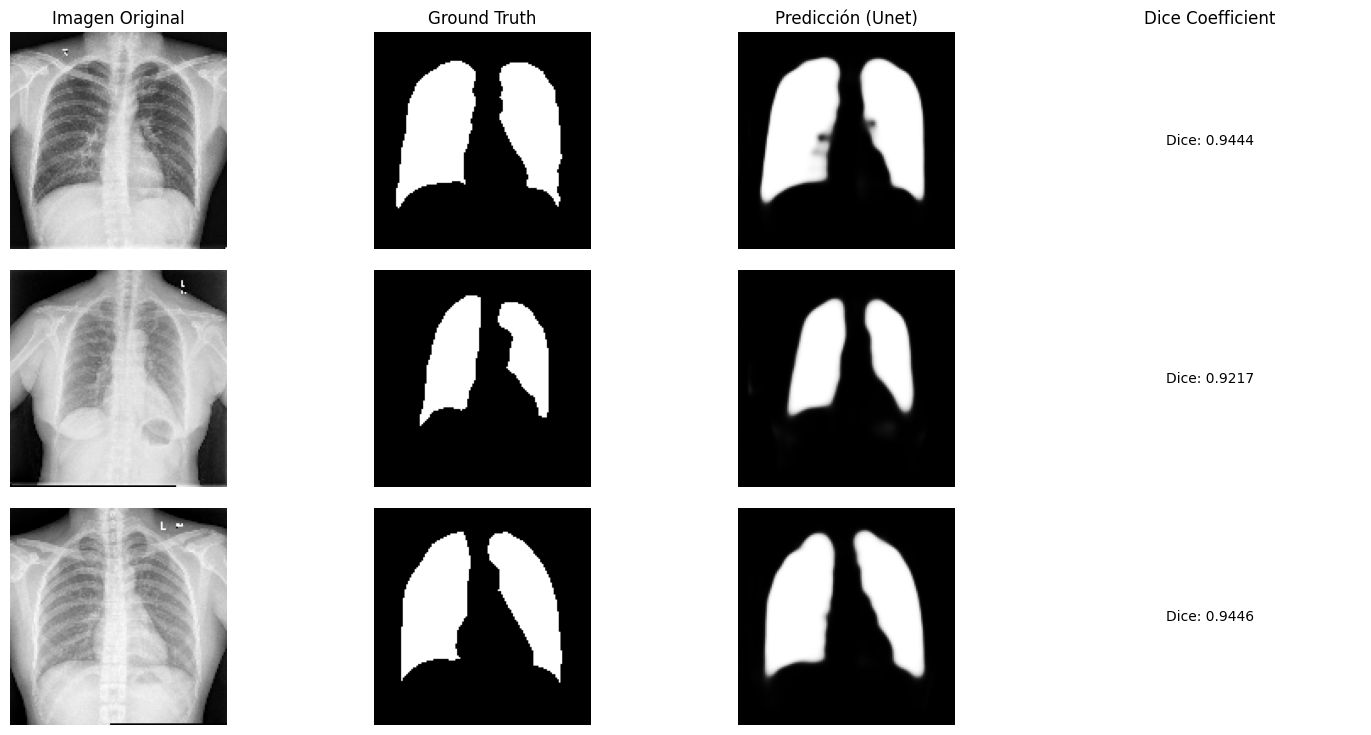

In [ ]:
# Obtener algunas muestras de datos de prueba
num_samples = 3  # Puedes ajustar este valor según la cantidad de muestras que desees mostrar
sample_images, sample_masks = next(test_datagen)

# Hacer predicciones con los modelos
predictions_unet = unet.predict(sample_images)
predictions_unet_normalized = predictions_unet / 255.0

# Calcular el coeficiente de Dice para cada muestra
dice_values = [dice_coef(sample_masks[i], predictions_unet[i]) for i in range(num_samples)]

# Calcular el coeficiente de Dice para cada muestra normalizada
#dice_values = [dice_coef(sample_masks[i], predictions_unet_normalized[i]) for i in range(num_samples)]

# Crear una matriz para visualizar las imágenes
fig, axes = plt.subplots(num_samples, 4, figsize=(18, 9))

# Configurar títulos de las columnas
col_titles = ['Imagen Original', 'Ground Truth', 'Predicción (Unet)', 'Dice Coefficient']

for i in range(num_samples):
    # Imágenes originales
    axes[i, 0].imshow(sample_images[i, :, :, 0], cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title(col_titles[0])

    # Ground Truth
    axes[i, 1].imshow(sample_masks[i, :, :, 0], cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title(col_titles[1])

    # Predicciones del modelo UNet
    #axes[i, 2].imshow(predictions_unet[i, :, :, 0], cmap='gray')
    #axes[i, 2].axis('off')
    #if i == 0:
    #    axes[i, 2].set_title(col_titles[2])

    # Predicciones del modelo UNet normalizada
    axes[i, 2].imshow(predictions_unet_normalized[i, :, :, 0], cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title(col_titles[2])

    # Dice Coefficient
    axes[i, 3].text(0.5, 0.5, f'Dice: {dice_values[i]:.4f}', fontsize=10, ha='center', va='center')
    axes[i, 3].axis('off')
    if i == 0:
        axes[i, 3].set_title(col_titles[3])

# Ajustar el espaciado entre subgráficos
plt.subplots_adjust(wspace=0.2, hspace=0.1)

plt.show()




1/1 [==============================] - 0s 260ms/step


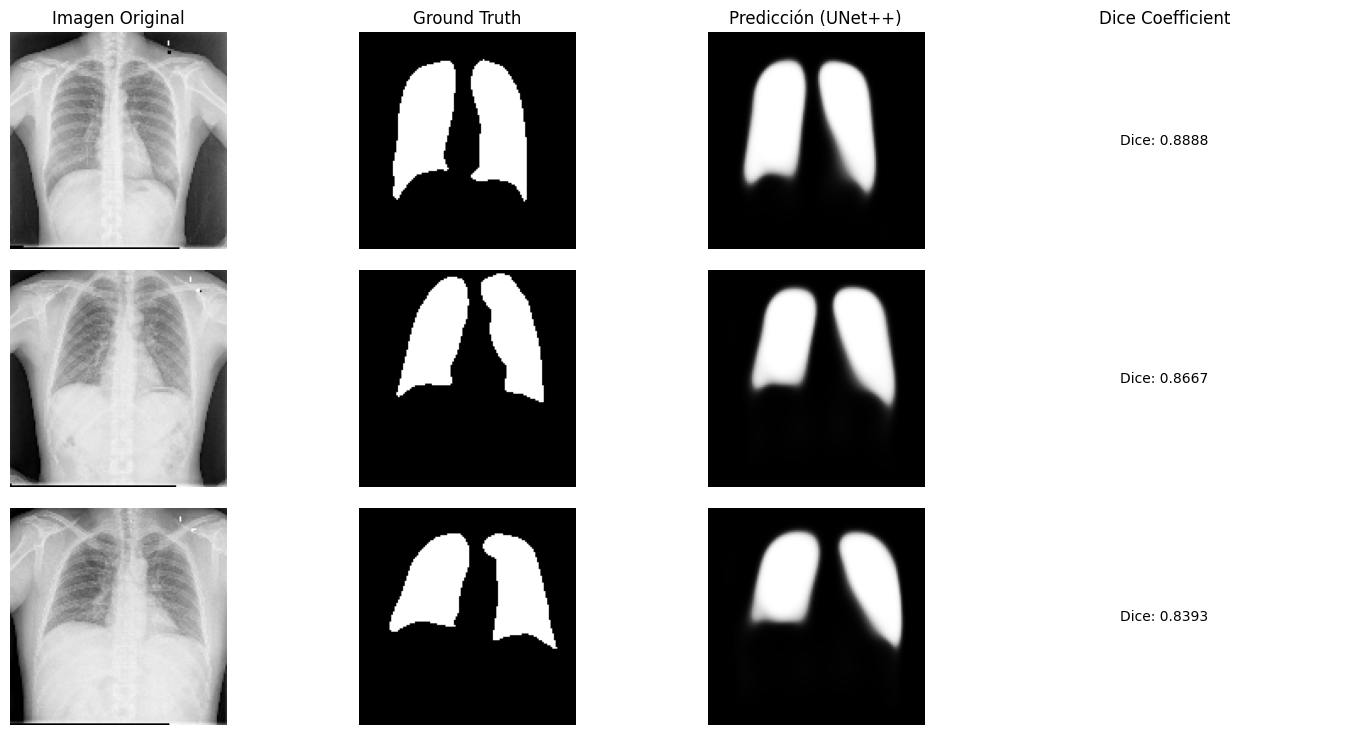

In [ ]:
# Obtener algunas muestras de datos de prueba
num_samples = 3  # Puedes ajustar este valor según la cantidad de muestras que desees mostrar
sample_images, sample_masks = next(test_datagen)

# Hacer predicciones con UNet++
predictions_unetplus = unetplus.predict(sample_images)
predictions_unetplus_normalized = predictions_unetplus / 255.0

# Calcular el coeficiente de Dice para cada muestra
dice_values_unetplus = [dice_coef(sample_masks[i], predictions_unetplus[i]) for i in range(num_samples)]


# Crear una matriz para visualizar las imágenes
fig, axes = plt.subplots(num_samples, 4, figsize=(18, 9))

# Configurar títulos de las columnas
col_titles = ['Imagen Original', 'Ground Truth', 'Predicción (UNet++)', 'Dice Coefficient']

for i in range(num_samples):
    # Imágenes originales
    axes[i, 0].imshow(sample_images[i, :, :, 0], cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title(col_titles[0])

    # Ground Truth
    axes[i, 1].imshow(sample_masks[i, :, :, 0], cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title(col_titles[1])

    # Predicciones del modelo UNet++
    axes[i, 2].imshow(predictions_unetplus_normalized[i, :, :, 0], cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title(col_titles[2])

    # Dice Coefficient
    axes[i, 3].text(0.5, 0.5, f'Dice: {dice_values_unetplus[i]:.4f}', fontsize=10, ha='center', va='center')
    axes[i, 3].axis('off')
    if i == 0:
        axes[i, 3].set_title(col_titles[3])

# Ajustar el espaciado entre subgráficos
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.show()


1/1 [==============================] - 1s 1s/step


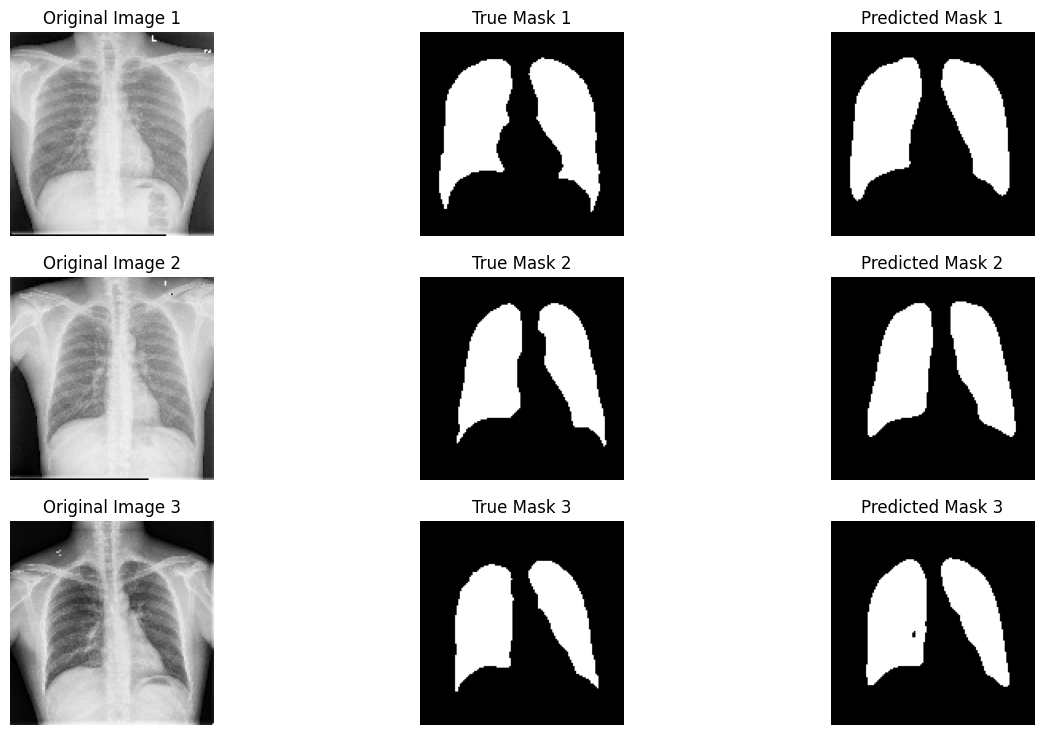

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que tienes la imagen original en sample_image (shape: [batch, height, width, channels])
# y las máscaras binarias en binary_mask_true y binary_mask_pred (shape: [batch, height, width, 1])

# Obtener tres muestras de datos de prueba
samples = [next(test_datagen) for _ in range(3)]

# Crear una figura con tres filas y tres columnas
plt.figure(figsize=(15, 9))

for i, (sample_image, sample_mask_true) in enumerate(samples, 1):
    # Hacer predicciones con UNet en las muestras de prueba
    sample_mask_pred = unet.predict(sample_image)

    # Convertir las máscaras a imágenes binarias (0 o 1)
    binary_mask_true = (sample_mask_true > 0.4).astype(np.uint8)
    binary_mask_pred = (sample_mask_pred > 0.40).astype(np.uint8)

    # Subgráfico para la imagen original
    plt.subplot(3, 3, i * 3 - 2)
    plt.imshow(sample_image[0, :, :, 0], cmap='gray')
    plt.title(f'Original Image {i}')
    plt.axis('off')

    # Subgráfico para la máscara verdadera
    plt.subplot(3, 3, i * 3 - 1)
    plt.imshow(binary_mask_true[0, :, :, 0], cmap='gray')
    plt.title(f'True Mask {i}')
    plt.axis('off')

    # Subgráfico para la máscara predicha
    plt.subplot(3, 3, i * 3)
    plt.imshow(binary_mask_pred[0, :, :, 0], cmap='gray')
    plt.title(f'Predicted Mask {i}')
    plt.axis('off')

plt.show()


1/1 [==============================] - 0s 28ms/step


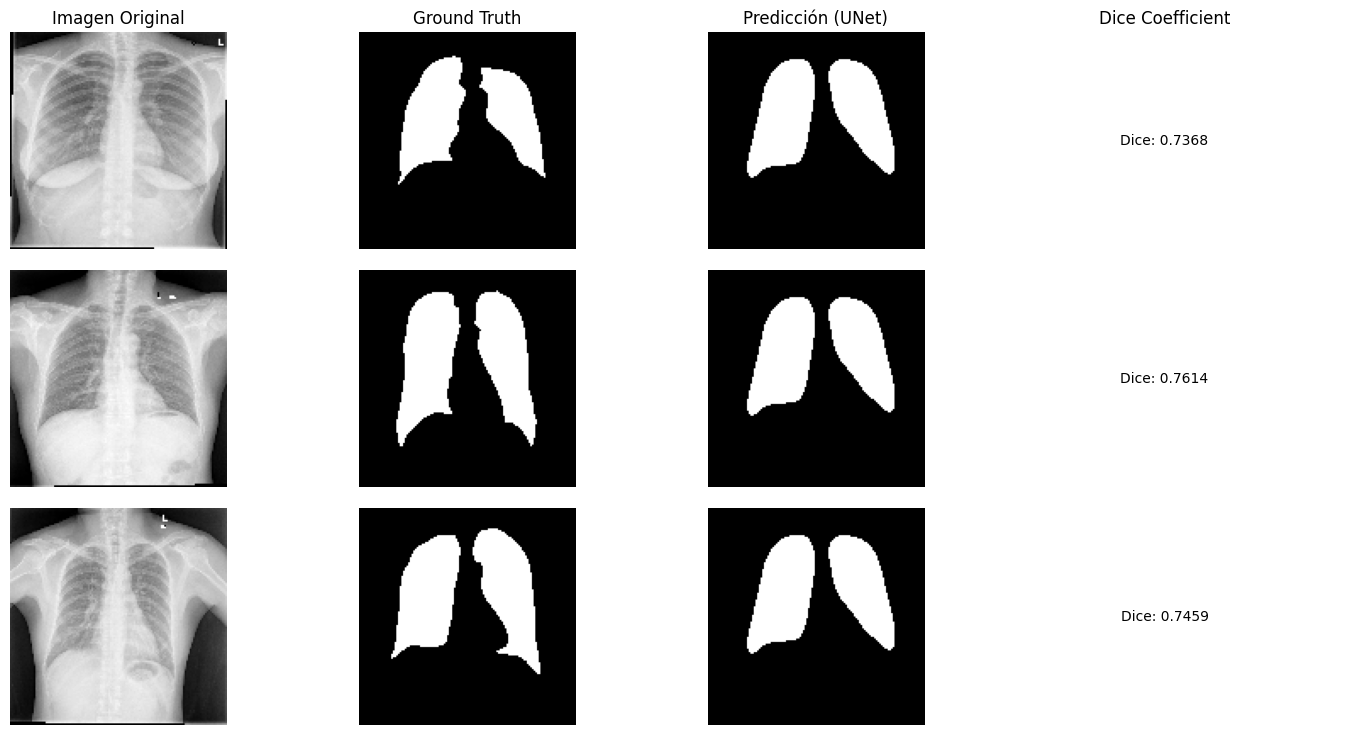

In [ ]:
# Obtener algunas muestras de datos de prueba
num_samples = 3  # Puedes ajustar este valor según la cantidad de muestras que desees mostrar
sample_images, sample_masks = next(test_datagen)

# Hacer predicciones con UNet
predictions_unet = unet.predict(sample_images)
predictions_unet_normalized = predictions_unet / 255.0

binary_mask_true = (sample_mask_true > 0.4).astype(np.uint8)
binary_mask_pred = (sample_mask_pred > 0.4).astype(np.uint8)

# Calcular el coeficiente de Dice para cada muestra
dice_values_unet = [dice_coef(sample_masks[i], predictions_unet[i]) for i in range(num_samples)]


# Crear una matriz para visualizar las imágenes
fig, axes = plt.subplots(num_samples, 4, figsize=(18, 9))

# Configurar títulos de las columnas
col_titles = ['Imagen Original', 'Ground Truth', 'Predicción (UNet)', 'Dice Coefficient']

for i in range(num_samples):
    # Imágenes originales
    axes[i, 0].imshow(sample_images[i, :, :, 0], cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title(col_titles[0])

    # Ground Truth
    axes[i, 1].imshow(sample_masks[i, :, :, 0], cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title(col_titles[1])

    # Predicciones del modelo UNet
    axes[i, 2].imshow(binary_mask_pred[0, :, :, 0], cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title(col_titles[2])

    # Dice Coefficient
    axes[i, 3].text(0.5, 0.5, f'Dice: {dice_values_unet[i]:.4f}', fontsize=10, ha='center', va='center')
    axes[i, 3].axis('off')
    if i == 0:
        axes[i, 3].set_title(col_titles[3])

# Ajustar el espaciado entre subgráficos
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.show()


1/1 [==============================] - 0s 27ms/step


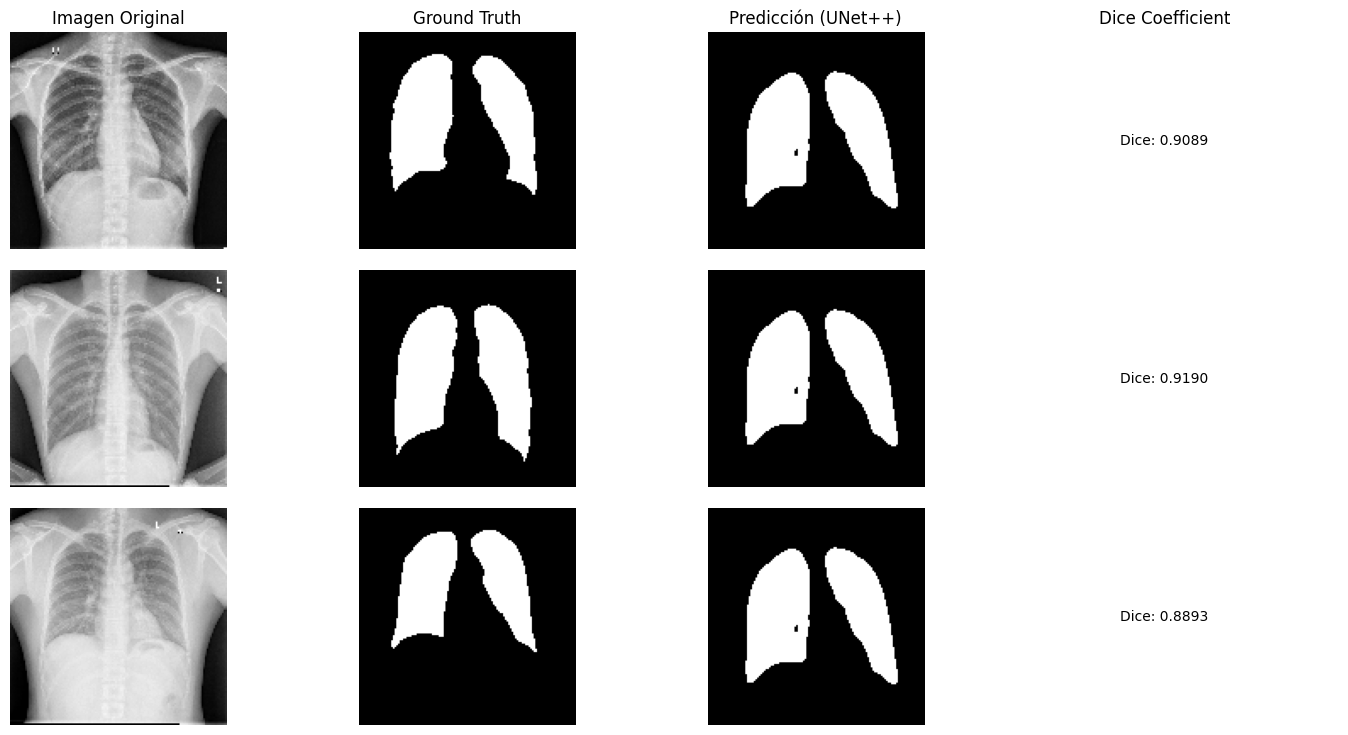

In [ ]:
# Obtener algunas muestras de datos de prueba
num_samples = 3  # Puedes ajustar este valor según la cantidad de muestras que desees mostrar
sample_images, sample_masks = next(test_datagen)

# Hacer predicciones con UNet++
predictions_unetplus = unetplus.predict(sample_images)
predictions_unetplus_normalized = predictions_unetplus / 255.0

binary_mask_true = (sample_mask_true > 0.4).astype(np.uint8)
binary_mask_pred = (sample_mask_pred > 0.4).astype(np.uint8)

# Calcular el coeficiente de Dice para cada muestra
dice_values_unetplus = [dice_coef(sample_masks[i], predictions_unetplus[i]) for i in range(num_samples)]


# Crear una matriz para visualizar las imágenes
fig, axes = plt.subplots(num_samples, 4, figsize=(18, 9))

# Configurar títulos de las columnas
col_titles = ['Imagen Original', 'Ground Truth', 'Predicción (UNet++)', 'Dice Coefficient']

for i in range(num_samples):
    # Imágenes originales
    axes[i, 0].imshow(sample_images[i, :, :, 0], cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title(col_titles[0])

    # Ground Truth
    axes[i, 1].imshow(sample_masks[i, :, :, 0], cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title(col_titles[1])

    # Predicciones del modelo UNet++
    axes[i, 2].imshow(binary_mask_pred[0, :, :, 0], cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title(col_titles[2])

    # Dice Coefficient
    axes[i, 3].text(0.5, 0.5, f'Dice: {dice_values_unetplus[i]:.4f}', fontsize=10, ha='center', va='center')
    axes[i, 3].axis('off')
    if i == 0:
        axes[i, 3].set_title(col_titles[3])

# Ajustar el espaciado entre subgráficos
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.show()


In [ ]:
#Valores dice Unet

min_val = min(val_dice)
print(min_val)

prom_val = sum(val_dice) / len(val_dice)
print(prom_val)

max_val = max(val_dice)
print(max_val)

#Valores dice Unet++

min_val2 = min(val_dice2)
print(min_val)

prom_val2 = sum(val_dice2) / len(val_dice2)
print(prom_val)

max_val2 = max(val_dice2)
print(max_val)



0.2897939682006836
0.6954533636569977
0.9199608564376831
0.2897939682006836
0.6954533636569977
0.9199608564376831


1/1 [==============================] - 0s 27ms/step


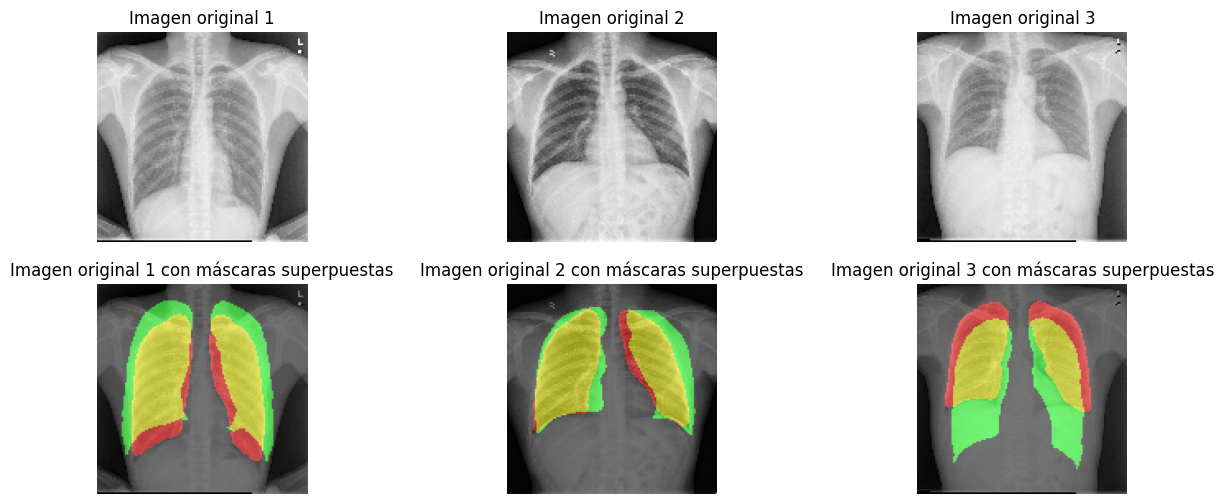

In [ ]:
#Unet

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Obtener tres muestras de datos de prueba
samples = [next(test_datagen) for _ in range(3)]

# Crear una figura con dos filas y tres columnas
plt.figure(figsize=(15, 6))

for i, (sample_image, sample_mask_true) in enumerate(samples, 1):
    # Hacer predicciones con UNet++ en las muestras de prueba
    sample_mask_pred = unet.predict(sample_image)

    # Convertir las máscaras a imágenes binarias (0 o 1)
    binary_mask_true = (sample_mask_true > 0.4).astype(np.uint8)
    binary_mask_pred = (sample_mask_pred > 0.4).astype(np.uint8)

    # Crear imagen RGB para superposición
    overlay_image_rgb = np.stack([binary_mask_pred[0, :, :, 0] * 255, binary_mask_true[0, :, :, 0] * 255, np.zeros_like(binary_mask_true[0, :, :, 0])], axis=-1)

    # Convertir la imagen a formato PIL
    overlay_image_pil = Image.fromarray(overlay_image_rgb.astype(np.uint8), mode='RGB')

    # Redimensionar la imagen original para que ambas tengan el mismo tamaño
    sample_image_resized = Image.fromarray((sample_image[0, :, :, 0] * 255).astype(np.uint8), mode='L').resize(overlay_image_pil.size)

    # Superponer la imagen en la original
    blended_image = Image.blend(sample_image_resized.convert("RGB"), overlay_image_pil, alpha=0.5)

    # Subgráfico para la imagen original
    plt.subplot(2, 3, i)
    plt.imshow(sample_image[0, :, :, 0], cmap='gray')
    plt.title(f'Imagen original {i}')
    plt.axis('off')

    # Subgráfico para la imagen con superposición
    plt.subplot(2, 3, i + 3)
    plt.imshow(blended_image, cmap='gray')
    plt.title(f'Imagen original {i} con máscaras superpuestas')
    plt.axis('off')

plt.show()


1/1 [==============================] - 0s 32ms/step


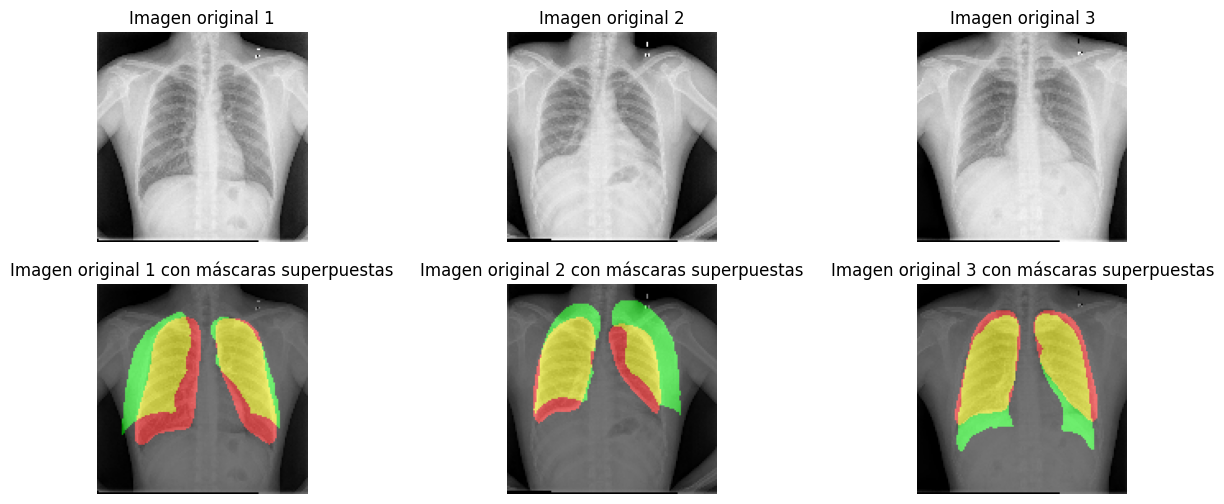

In [ ]:
#Unet++

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Obtener tres muestras de datos de prueba
samples = [next(test_datagen) for _ in range(3)]

# Crear una figura con dos filas y tres columnas
plt.figure(figsize=(15, 6))

for i, (sample_image, sample_mask_true) in enumerate(samples, 1):
    # Hacer predicciones con UNet++ en las muestras de prueba
    sample_mask_pred = unetplus.predict(sample_image)

    # Convertir las máscaras a imágenes binarias (0 o 1)
    binary_mask_true = (sample_mask_true > 0.4).astype(np.uint8)
    binary_mask_pred = (sample_mask_pred > 0.4).astype(np.uint8)

    # Crear imagen RGB para superposición
    overlay_image_rgb = np.stack([binary_mask_pred[0, :, :, 0] * 255, binary_mask_true[0, :, :, 0] * 255, np.zeros_like(binary_mask_true[0, :, :, 0])], axis=-1)

    # Convertir la imagen a formato PIL
    overlay_image_pil = Image.fromarray(overlay_image_rgb.astype(np.uint8), mode='RGB')

    # Redimensionar la imagen original para que ambas tengan el mismo tamaño
    sample_image_resized = Image.fromarray((sample_image[0, :, :, 0] * 255).astype(np.uint8), mode='L').resize(overlay_image_pil.size)

    # Superponer la imagen en la original
    blended_image = Image.blend(sample_image_resized.convert("RGB"), overlay_image_pil, alpha=0.5)

    # Subgráfico para la imagen original
    plt.subplot(2, 3, i)
    plt.imshow(sample_image[0, :, :, 0], cmap='gray')
    plt.title(f'Imagen original {i}')
    plt.axis('off')

    # Subgráfico para la imagen con superposición
    plt.subplot(2, 3, i + 3)
    plt.imshow(blended_image, cmap='gray')
    plt.title(f'Imagen original {i} con máscaras superpuestas')
    plt.axis('off')

plt.show()